# Imports

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data loading and cleaning

In [2]:
df = pd.read_csv('../data/employee_churn_data.csv')
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


In [3]:
departments = sorted(set(df.department), key=lambda x: x.lower())

In [4]:
for i, dep in enumerate(departments):
    df.department = df.department.replace(dep, i)

In [5]:
df.salary = df.salary.replace('low', 0)
df.salary = df.salary.replace('medium', 1)
df.salary = df.salary.replace('high', 2)

In [6]:
df.left = df.left.replace('no', 0)
df.left = df.left.replace('yes', 1)

In [7]:
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,6,0,0.577569,3,0,5.0,0.626759,0,180.866070,0
1,6,0,0.751900,3,1,6.0,0.443679,0,182.708149,0
2,9,0,0.722548,3,1,6.0,0.446823,0,184.416084,0
3,4,0,0.675158,4,2,8.0,0.440139,0,188.707545,0
4,8,0,0.676203,3,2,5.0,0.577607,1,179.821083,0


In [8]:
normalized_df = df.copy()

for col in ['review', 'tenure', 'satisfaction', 'avg_hrs_month']:
    normalized_df[col] = (normalized_df[col] - normalized_df[col].mean())/normalized_df[col].std()

normalized_df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,6,0,-0.870478,3,0,-1.099441,0.770170,0,-0.915719,0
1,6,0,1.173100,3,1,-0.392943,-0.384507,0,-0.471291,0
2,9,0,0.829033,3,1,-0.392943,-0.364676,0,-0.059227,0
3,4,0,0.273507,4,2,1.020053,-0.406835,0,0.976149,0
4,8,0,0.285755,3,2,-1.099441,0.460174,1,-1.167837,0


# Visualization

In [9]:
df_left = normalized_df[normalized_df.left == 1]
df_stay = normalized_df[normalized_df.left == 0]

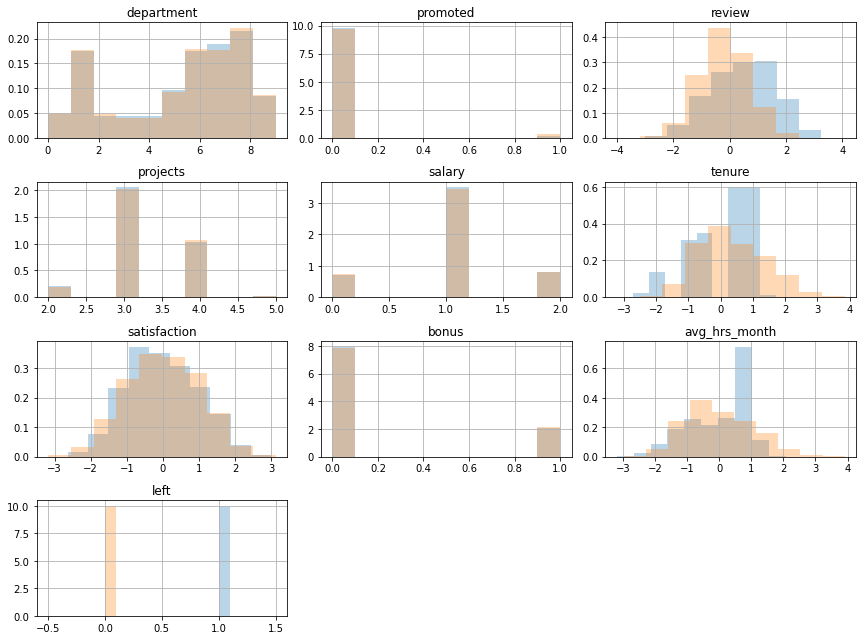

In [10]:
axes = df_left.hist(figsize=(12, 9), alpha=0.3, density=True)

df_stay.hist(figsize=(12, 9), ax=list(itertools.chain.from_iterable(axes))[:10], alpha=0.3, density=True)

plt.tight_layout()

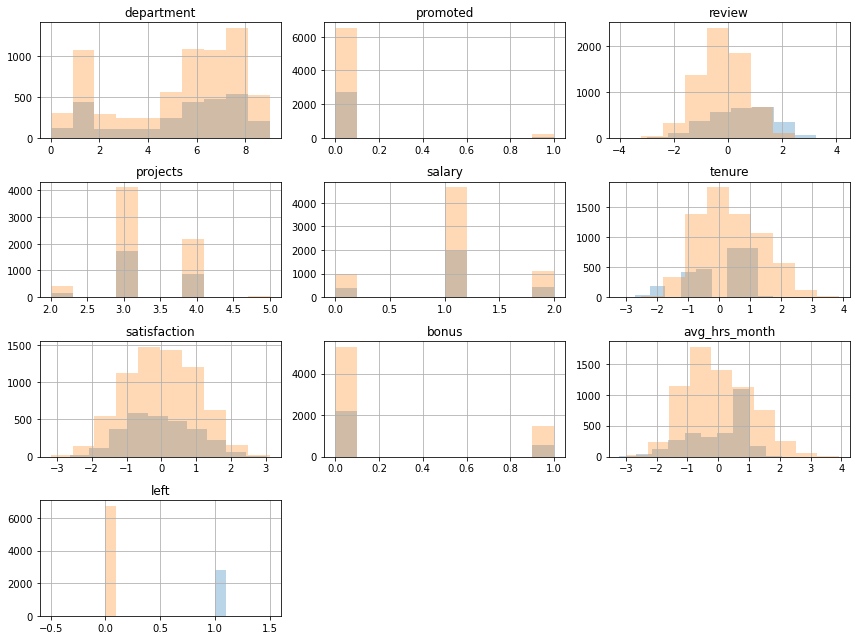

In [11]:
axes = df_left.hist(figsize=(12, 9), alpha=0.3)

df_stay.hist(figsize=(12, 9), ax=list(itertools.chain.from_iterable(axes))[:10], alpha=0.3)

plt.tight_layout()

# Model development

In [12]:
def train_test_split(data, percent_train):
    num_data = len(data)
    
    all_indices = np.random.choice(num_data, num_data)
    
    split_index = int(np.floor(num_data*percent_train))
    train_indices, test_indices = np.split(all_indices, [split_index])
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
ndf_train, ndf_test = train_test_split(normalized_df, percent_train=0.9)
ndf_train.shape, ndf_test.shape

((8586, 10), (954, 10))

In [14]:
quant_ndf_train = ndf_train.drop(columns=['department', 'promoted', 'projects', 'salary', 'bonus'])
cat_ndf_train   = ndf_train.drop(columns=['review', 'tenure', 'satisfaction', 'avg_hrs_month'])

quant_ndf_test = ndf_test.drop(columns=['department', 'promoted', 'projects', 'salary', 'bonus'])
cat_ndf_test   = ndf_test.drop(columns=['review', 'tenure', 'satisfaction', 'avg_hrs_month'])

## Naive Bayes

General description of technique:
    
* Assumes that all variables are independent of each other
* Uses Bayes' Theorem to make an updated prediction of the probability of a result given each of the variables
    * Recall Bayes' Theorem:
        * $P(\text{A}|\text{B}) = \frac{P(\text{B}|\text{A}) * P(\text{A})}{P(\text{B})}$
        * $ \text{posterior} = \frac{\text{likelihood} * \text{prior}}{\text{evidence}} $
    * For example:
        * $P(\text{left}|\text{promoted}) = \frac{P(\text{promoted}|\text{left})*P(\text{left})}{P(\text{promoted})}$
* Note that `likelihood` and `prior` should all be computed using _only_ the training set.
* Also note, `evidence` is a constant for a given observation, so it can be ignored. It is essentially the normalization of the distribution.
* For multiple $x$ (because of the assumption of independence), the total probability can be written as $$ P(y | x_1, ..., x_n) = P(y) \prod_{i=1}^n P(x_i|y)$$
* We can of course use the log-probability instead $$ \log{P(y | x_1, ..., x_n)} = \log{P(y)} + \sum_{i=1}^n \log{P(x_i|y)} $$
* This requires the assumption of a given likelihood for each possible output condition.
    * For example, for "Gaussian Naive Bayes":
        * $ P(x_i|y) = \frac{1}{\sigma \sqrt{2\pi}} \exp{-\frac{1}{2}\big(\frac{x - \mu}{\sigma}\big)^2}$
* The likelihoods for the categorical features must be handled differently: $$ P(x_i = t | y=c; \alpha ) = \frac{N_{xc} + \alpha}{N_c + \alpha n_i} $$
    * $N_xc$ is the number of times feature $x$ appears in the data with category $c$
    * $N_c$ is the number of counts of category $c$
    * $\alpha$ is a smoothing parameter
    * $n_i$ is the number of categories

### Gaussian NB only

In [15]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(
    quant_ndf_train.drop(columns=['left']),
    quant_ndf_train['left']
)

predictions = gnb.predict(
    quant_ndf_train.drop(columns=['left'])
)

incorrect = np.sum(np.abs(predictions - quant_ndf_train['left']))
percent_incorrect = incorrect / len(quant_ndf_train)
gnb_train_acc = 1-percent_incorrect
print("Training accuracy:", gnb_train_acc)

predictions = gnb.predict(
    quant_ndf_test.drop(columns=['left'])
)

incorrect = np.sum(np.abs(predictions - quant_ndf_test['left']))
percent_incorrect = incorrect / len(quant_ndf_test)
gnb_test_acc = 1-percent_incorrect
print("Testing accuracy:", gnb_test_acc)

Training accuracy: 0.7529699510831587
Testing accuracy: 0.729559748427673


### Categorical NB only

In [16]:
from sklearn.naive_bayes import CategoricalNB

cnb = CategoricalNB()

cnb.fit(
    cat_ndf_train.drop(columns=['left']),
    cat_ndf_train['left']
)

cnb_predictions_train = cnb.predict(
    cat_ndf_train.drop(columns=['left'])
)

incorrect = np.sum(np.abs(cnb_predictions_train - cat_ndf_train['left']))
percent_incorrect = incorrect / len(cat_ndf_train)
cnb_train_acc = 1-percent_incorrect
print("Training accuracy:", cnb_train_acc)

cnb_predictions_test = cnb.predict(
    cat_ndf_test.drop(columns=['left'])
)

incorrect = np.sum(np.abs(cnb_predictions_test - cat_ndf_test['left']))
percent_incorrect = incorrect / len(cat_ndf_test)
cnb_test_acc = 1-percent_incorrect
print("Testing accuracy:", cnb_test_acc)

Training accuracy: 0.713487071977638
Testing accuracy: 0.6834381551362683


### Gaussian NB + Categorical NB

In [17]:
gnb = GaussianNB()
cnb = CategoricalNB()

gnb.fit(
    quant_ndf_train.drop(columns=['left']),
    quant_ndf_train['left']
)

cnb.fit(
    cat_ndf_train.drop(columns=['left']),
    cat_ndf_train['left']
)

gnb_probs = gnb.predict_log_proba(
    quant_ndf_train.drop(columns=['left'])
)

cnb_probs = cnb.predict_log_proba(
    cat_ndf_train.drop(columns=['left'])
)

total_probs = gnb_probs + cnb_probs

predictions = np.zeros_like(ndf_train['left'])
predictions[np.where(total_probs[:, 0] < total_probs[:, 1])] = 1

incorrect = np.sum(np.abs(predictions - ndf_train['left']))
percent_incorrect = incorrect / len(ndf_train)
total_train_acc = 1-percent_incorrect
print("Training accuracy:", total_train_acc)

gnb_probs = gnb.predict_log_proba(
    quant_ndf_test.drop(columns=['left'])
)

cnb_probs = cnb.predict_log_proba(
    cat_ndf_test.drop(columns=['left'])
)

total_probs = gnb_probs + cnb_probs

predictions = np.zeros_like(ndf_test['left'])
predictions[np.where(total_probs[:, 0] < total_probs[:, 1])] = 1

incorrect = np.sum(np.abs(predictions - ndf_test['left']))
percent_incorrect = incorrect / len(ndf_test)
total_test_acc = 1-percent_incorrect
print("Testing accuracy:", total_test_acc)

Training accuracy: 0.7352667132541346
Testing accuracy: 0.7106918238993711


### QDA

Quadratic Discriminant Analysis (QDA), is almost identical to Gaussian Naive Bayes, but it takes into account possible correlation between variables. It does this by replacing the independent Gaussian distributions for $P(x|y)$ with a multi-variate Gaussian that has a non-diagonal correlation matrix.

In QDA, the new log of the posterior is: $$ \log{(P(y=k|x)} \\= \log{P(x|y=k)} + \log{P(y=k)} + C_{st} \\= -\frac{1}{2}\log{|\Sigma_k|}  - \frac{1}{2}(x-\mu_k)^t\Sigma_k^{-1}(x-\mu_k) + \log{P(y=k)}$$

In [30]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis(store_covariance=True)

qda.fit(
    quant_ndf_train.drop(columns=['left']),
    quant_ndf_train['left']
)

predictions = qda.predict(
    quant_ndf_train.drop(columns=['left'])
)

incorrect = np.sum(np.abs(predictions - quant_ndf_train['left']))
percent_incorrect = incorrect / len(quant_ndf_train)
qda_train_acc = 1-percent_incorrect
print("Training accuracy:", qda_train_acc)

predictions = qda.predict(
    quant_ndf_test.drop(columns=['left'])
)

incorrect = np.sum(np.abs(predictions - quant_ndf_test['left']))
percent_incorrect = incorrect / len(quant_ndf_test)
qda_test_acc = 1-percent_incorrect
print("Testing accuracy:", qda_test_acc)

Training accuracy: 0.7655485674353599
Testing accuracy: 0.7463312368972747


In [31]:
print('GNB:')
print(f'\tTrain: {gnb_train_acc}')
print(f'\tTest:  {gnb_test_acc}')

print('CNB:')
print(f'\tTrain: {cnb_train_acc}')
print(f'\tTest:  {cnb_test_acc}')

print('GNB+CNB:')
print(f'\tTrain: {total_train_acc}')
print(f'\tTest:  {total_test_acc}')

print('QDA:')
print(f'\tTrain: {qda_train_acc}')
print(f'\tTest:  {qda_test_acc}')

GNB:
	Train: 0.7529699510831587
	Test:  0.729559748427673
CNB:
	Train: 0.713487071977638
	Test:  0.6834381551362683
GNB+CNB:
	Train: 0.7352667132541346
	Test:  0.7106918238993711
QDA:
	Train: 0.7655485674353599
	Test:  0.7463312368972747


# SVC (SVM)

Support Vector Classifiers (SVCs), a type of Support Vector Machine (SVM), work by attempting t

Here are the key points that help me to understand how SVCs work:

* SVCs try to build a hyperplane that separates the two classes of points
    * They do this by trying to maximize the distance between the hyperplane and all of the nearest points
        * The distance to the nearest points is called called the "margin"
        * These points are called the "support vectors"
            * "Support vectors are the points that would change the position of the hyperplane if they wer ere removed"
* SVCs make predictions by taking the sign of the weighted sum of the distances between a test point and all of the support vectors: $ \sum_{i \in SV} y_i \alpha_i K(x_i, x) + b$
    * The "distance" is computed using a kernel function $K$ (e.g., RBF)
    * $y_i$ is the class of support vector $i$
    * $x_i$ is support vector $i$
    * $\alpha_i$ is the "dual coefficient", which I don't understand what it is yet...
    

In [33]:
from sklearn import svm

results = {}

for name, train, test in zip(
        ['quant', 'categorical', 'all'],
        [quant_ndf_train, cat_ndf_train, ndf_train],
        [quant_ndf_test,  cat_ndf_test,  ndf_test],
    ):
    
    print(name)
    
    X = train.drop(columns='left')
    y = train['left']

    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        model = svm.SVC(kernel=kernel)
        model.fit(X, y)

        svm_predictions_train = model.predict(X)

        print(f"\tKernel: {kernel}")
        incorrect = np.sum(np.abs(svm_predictions_train - train['left']))
        percent_incorrect = incorrect / len(train)
        print(f"\t\tTraining accuracy (quant):", 1-percent_incorrect)

        svm_predictions_test = model.predict(test.drop(columns='left'))

        incorrect = np.sum(np.abs(svm_predictions_test - test['left']))
        percent_incorrect = incorrect / len(test)
        print(f"\t\tTesting accuracy (quant):", 1-percent_incorrect)
        
        results[name] = {'train': train, 'test': test}

quant
	Kernel: linear
		Training accuracy (quant): 0.713487071977638
		Testing accuracy (quant): 0.6834381551362683
	Kernel: poly
		Training accuracy (quant): 0.7912881434894014
		Testing accuracy (quant): 0.7515723270440251
	Kernel: rbf
		Training accuracy (quant): 0.8662939669228977
		Testing accuracy (quant): 0.8469601677148847
	Kernel: sigmoid
		Training accuracy (quant): 0.5582343349638947
		Testing accuracy (quant): 0.5429769392033543
categorical
	Kernel: linear
		Training accuracy (quant): 0.713487071977638
		Testing accuracy (quant): 0.6834381551362683
	Kernel: poly
		Training accuracy (quant): 0.713487071977638
		Testing accuracy (quant): 0.6834381551362683
	Kernel: rbf
		Training accuracy (quant): 0.713487071977638
		Testing accuracy (quant): 0.6834381551362683
	Kernel: sigmoid
		Training accuracy (quant): 0.6227579781038901
		Testing accuracy (quant): 0.6058700209643606
all
	Kernel: linear
		Training accuracy (quant): 0.713487071977638
		Testing accuracy (quant): 0.683438155

In [41]:
train = quant_ndf_train
test  = quant_ndf_test

X = train.drop(columns='left')
y = train['left']

model = svm.SVC(kernel='rbf')
model.fit(X, y)

svm_predictions_train = model.predict(X)

incorrect = np.sum(np.abs(svm_predictions_train - train['left']))
percent_incorrect = incorrect / len(train)
print(f"\t\tTraining accuracy (quant):", 1-percent_incorrect)

svm_predictions_test = model.predict(test.drop(columns='left'))

incorrect = np.sum(np.abs(svm_predictions_test - test['left']))
percent_incorrect = incorrect / len(test)
print(f"\t\tTesting accuracy (quant):", 1-percent_incorrect)


		Training accuracy (quant): 0.8662939669228977
		Testing accuracy (quant): 0.8469601677148847


In [42]:
model.support_vectors_.shape

(2977, 4)

In [45]:
train.shape

(8586, 5)

In [44]:
2977/954

3.120545073375262